# Lab work №6

First, let's prepare the data. Only the Date, Open, High, Low and Close parameters will be enough to perform the given task:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim

data = pd.read_csv('BTC-USD.csv')
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values(by=["Date"]) # sort by date
print(data)
X = data[['Open', 'High', 'Low']] # values
y = data['Close'] # labels
# convert data to tensors with float type
X, y = torch.tensor(X.values).float(), torch.tensor(y.values).float()
# split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=len(data)-1, shuffle=False)
y_train, y_test = y_train.unsqueeze(1), y_test.unsqueeze(1)


          Date          Open          High           Low         Close   
0   2022-12-14  17782.066406  18318.531250  17739.513672  17815.650391  \
1   2022-12-15  17813.644531  17846.744141  17322.589844  17364.865234   
2   2022-12-16  17364.546875  17505.525391  16584.701172  16647.484375   
3   2022-12-17  16646.982422  16800.589844  16614.029297  16795.091797   
4   2022-12-18  16795.609375  16815.386719  16697.820313  16757.976563   
..         ...           ...           ...           ...           ...   
361 2023-12-10  43728.382813  44034.625000  43593.285156  43779.699219   
362 2023-12-11  43792.019531  43808.375000  40234.578125  41243.832031   
363 2023-12-12  41238.734375  42048.304688  40667.562500  41450.222656   
364 2023-12-13  41468.464844  43429.781250  40676.867188  42890.742188   
365 2023-12-14  42884.261719  43288.300781  41968.000000  42607.230469   

        Adj Close       Volume  
0    17815.650391  25534481470  
1    17364.865234  20964448341  
2    16647.4

Let's define the parameters of the network and create a class of our neural network

In [2]:
epochs_number = 500
first_layer_nn = 128
second_layer_nn = 64

class MyNN(nn.Module): # inherit our neural network class from nn.Module
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(3, first_layer_nn) # define layers
        self.layer2 = nn.Linear(first_layer_nn, second_layer_nn)
        self.layer3 = nn.Linear(second_layer_nn, 1)
    def forward(self, x):
        x = f.relu(self.layer1(x))
        x = f.relu(self.layer2(x))
        x = self.layer3(x)
        return x

model = MyNN()


We will train the network using the stochastic gradient descent method with the Adam optimizer and using the root mean square loss function to measure errors

In [3]:
lossF = nn.MSELoss() # loss function
optimize = optim.Adam(model.parameters(), lr=0.001) # Use Adam optimizer
trainLosses, testLosses = [], []
for epoch in range(epochs_number): # training the network
    model.train()
    optimize.zero_grad() # reset gradients
    pred = model(X_train) # forward pass of the model for training data
    loss = lossF(pred, y_train) # calculate loss using mean squared error function
    loss.backward() # calculate gradients using backpropagation
    optimize.step() # update weights based on gradient descent
    trainLosses.append(loss.item())
    model.eval()
    with torch.no_grad(): # Evaluate the model on test data
        pred = model(X_test)
        testLoss = lossF(pred, y_test)
        testLosses.append(testLoss.item())
        print(f'Epoch {epoch}, Loss: {loss.item():.2f}, Test Loss: {testLoss.item():.2f}')


Epoch 0, Loss: 455993056.00, Test Loss: 955737280.00
Epoch 1, Loss: 382766368.00, Test Loss: 795528960.00
Epoch 2, Loss: 318241568.00, Test Loss: 650976512.00
Epoch 3, Loss: 259961872.00, Test Loss: 521703456.00
Epoch 4, Loss: 207883280.00, Test Loss: 411750336.00
Epoch 5, Loss: 163506368.00, Test Loss: 321526048.00
Epoch 6, Loss: 127165088.00, Test Loss: 247865952.00
Epoch 7, Loss: 97674152.00, Test Loss: 191663312.00
Epoch 8, Loss: 75193608.00, Test Loss: 144393232.00
Epoch 9, Loss: 56320612.00, Test Loss: 105534712.00
Epoch 10, Loss: 40817860.00, Test Loss: 74562912.00
Epoch 11, Loss: 28564400.00, Test Loss: 50291452.00
Epoch 12, Loss: 19006092.00, Test Loss: 31082098.00
Epoch 13, Loss: 11499206.00, Test Loss: 16812380.00
Epoch 14, Loss: 5989520.00, Test Loss: 7184044.50
Epoch 15, Loss: 2357487.25, Test Loss: 1800989.25
Epoch 16, Loss: 438970.94, Test Loss: 159268.38
Epoch 17, Loss: 25045.54, Test Loss: 1572301.88
Epoch 18, Loss: 832068.25, Test Loss: 5068063.50
Epoch 19, Loss: 2466

Let's create graphs

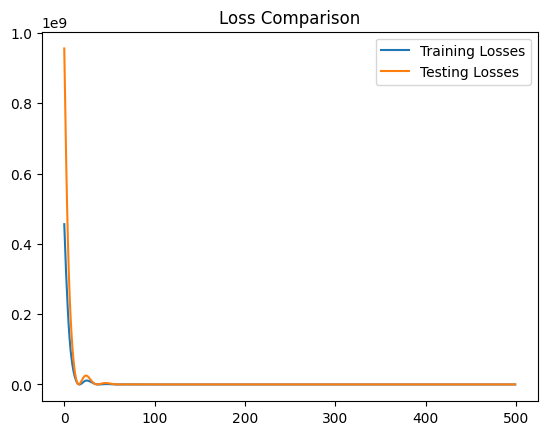

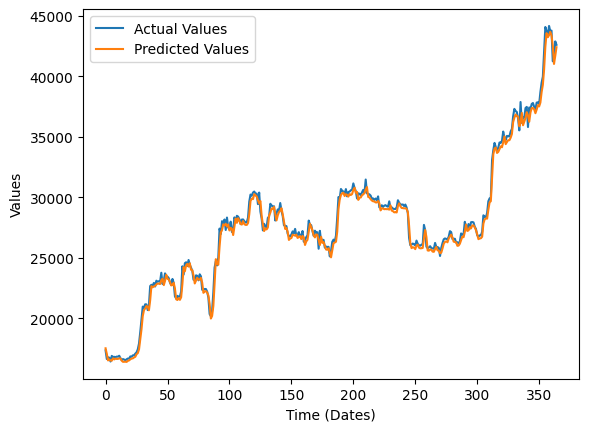

Predicted price for 2023-12-14 00:00:00: 42405.82421875
Actual price for 2023-12-14 00:00:00: 42607.230469
Difference: 201.406250


In [4]:
plt.plot(trainLosses, label='Training Losses')
plt.plot(testLosses, label='Testing Losses')
plt.title('Loss Comparison')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    pred = model(X_test)
plt.plot(y_test.numpy(), label='Actual Values')
plt.plot(pred.numpy(), label='Predicted Values')
plt.xlabel('Time (Dates)')
plt.ylabel('Values')
plt.legend()
plt.show()

forecastX = data.iloc[-1][['Open', 'High', 'Low']].astype(float).values
forecastX = torch.tensor(forecastX).float()
model.eval()
with torch.no_grad():
    forecastY = model(forecastX.unsqueeze(0)) # forecast the value

predicted_price = forecastY.item()
real_price = data.iloc[-1]["Close"]
print(f'Predicted price for {data.iloc[-1]["Date"]}: {predicted_price}')
print(f'Actual price for {data.iloc[-1]["Date"]}: {real_price}')
print(f'Difference: {abs(predicted_price-real_price):.6f}')
